## Code of "Neural Tangent Kernel Maximum Mean Discrepancy"

This file demonstrates

1. The computation of net-mmd statistic by training a 2-layer neural network (1 hidden layer), on the example of high dimensional Gaussian covariance shift in Subsection 4.1


2. The computation of testing power of the net-mmd statistic as in Figure 1 (2nd plot from left)

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F


### 1. net MMD statistic in one run

In [51]:
## gaussain covariance shift in R^d
np.random.seed(2021)

dim, rho =  100, 0.2 # Figure 1

# dim, rho = 2, 1.0 # Figure 2

nX, nY = 200, 200
X = np.float32( np.random.randn( nX, dim))
tmp = np.float32( np.random.randn( nY, dim+1))
Y = tmp[:,0:dim]+ np.sqrt( rho)*np.matmul(tmp[:,dim].reshape(nY,1), np.float32(np.ones(dim)).reshape((1,dim)) )

# splitting training and testing
idxX=torch.randperm(nX).numpy()
idxY=torch.randperm(nY).numpy()

nXtr= 100
nYtr= 100
nXte = nX-nXtr
nYte = nY-nYtr

ntr = nXtr+nYtr
nte = nXte+nYte

data_tr = torch.tensor( np.concatenate( (X[idxX[0:nXtr],:],  Y[idxY[0:nYtr],:]), axis=0) )
labels_tr = torch.tensor(np.concatenate( (np.zeros(nXtr),  np.ones(nYtr)), axis=0), dtype=int)

data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)

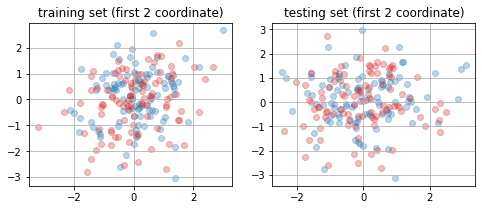

In [52]:
# plot 
fig = plt.figure(figsize=(8, 3))
tmp1=data_tr.numpy()
tmp2=labels_tr.numpy()
out1 =  tmp1[tmp2==0,:]
out2 =  tmp1[tmp2==1,:]

plt.subplot(121)
plt.scatter(out1[:,0], out1[:,1], c='tab:blue', alpha=0.3)
plt.scatter(out2[:,0], out2[:,1], c='tab:red', alpha=0.3)
plt.title('training set (first 2 coordinate)')
plt.grid()

tmp1=data_te.numpy()
tmp2=labels_te.numpy()
out1 =  tmp1[tmp2==0,:]
out2 =  tmp1[tmp2==1,:]
plt.subplot(122)
plt.scatter(out1[:,0], out1[:,1], c='tab:blue', alpha=0.3)
plt.scatter(out2[:,0], out2[:,1], c='tab:red', alpha=0.3)
plt.title('testing set (first 2 coordinate)')
plt.grid()
plt.show()


In [53]:
data_tr.shape, data_te.shape

(torch.Size([200, 100]), torch.Size([200, 100]))

In [54]:
device = torch.device("cpu")

In [55]:
# take a classification net
num_neurons = 512

class nn_one_hidden_layer(nn.Module):
    def __init__(self):
        super( nn_one_hidden_layer, self).__init__()
        input_dim = dim
        num_classes = 1
        
        self.fc1 = nn.Linear(input_dim, num_neurons ) 
        self.fc2 = nn.Linear(num_neurons, num_classes) 

    def forward(self, x):
        x = F.softplus(self.fc1(x)) #softplus activation function
        x = self.fc2(x)
        return x

In [56]:
# init model
model = nn_one_hidden_layer().to(device) #init model
# specificy 1st layer weights to be N(0,1) 
model.fc1.weight = torch.nn.parameter.Parameter(torch.randn(model.fc1.weight.shape))
model.fc1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.fc1.bias))
# specificy 2nd layer weights to be N(0,1/sqrt(M)) 
model.fc2.weight = torch.nn.parameter.Parameter(torch.randn(model.fc2.weight.shape)/np.sqrt(num_neurons))
model.fc2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.fc2.bias))
# make 2nd layer not trainable
model.fc2.weight.requires_grad = False
model.fc2.bias.requires_grad= False

# get f(xdata) at t=0
with torch.no_grad():
    fte0 = model(data_te)  

In [57]:
# print out initial model parameters
model.fc1.weight[0:3,0:5],  model.fc1.bias[0:3], model.fc2.weight[:,0:5],  model.fc2.bias

(tensor([[-6.2612e-01, -1.2335e+00, -1.0759e+00,  7.4078e-01,  2.3880e-01],
         [-3.3967e-01,  1.5728e-01, -5.3186e-01,  3.0084e-02,  2.5412e+00],
         [-2.0339e+00,  1.1011e-03, -1.2305e-01,  9.6095e-01, -4.1374e-01]],
        grad_fn=<SliceBackward>),
 tensor([0., 0., 0.], grad_fn=<SliceBackward>),
 tensor([[ 0.0183, -0.0203,  0.0070, -0.0105,  0.0350]]),
 Parameter containing:
 tensor([0.]))

In [58]:
# tarin 1-pass with batch size 1
sgd_lr = 1e-3
optimizer = optim.SGD(model.parameters(), 
                      lr=sgd_lr,
                      momentum=0, dampening=0, 
                      weight_decay=0, nesterov=False)
model.train()

for itr in range(0, ntr ):
    optimizer.zero_grad()
    
    # forward pass
    outputi = model(data_tr[itr,:]).reshape([-1,1])
    loss = F.nll_loss( torch.cat( (outputi, -outputi),1),
                      labels_tr[itr].reshape([1]), reduction='sum')
    
    #backward pass
    loss.backward()
    optimizer.step() 


# get f(xdata) at t=T
with torch.no_grad():
    fteT = model(data_te)   

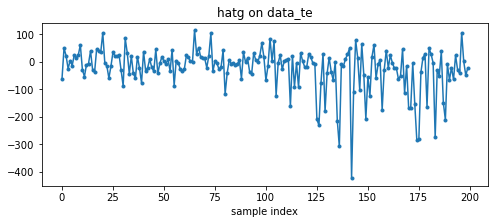

In [59]:
gte = (fteT - fte0)/sgd_lr

fig = plt.figure(figsize= (8,3))
plt.plot(gte,'.-')
plt.title('hatg on data_te')
plt.xlabel('sample index')
plt.show()


In [60]:
# print out  model parameters after training
model.fc1.weight[0:3,0:5],  model.fc1.bias[0:3], model.fc2.weight[:,0:5],  model.fc2.bias

(tensor([[-6.2612e-01, -1.2334e+00, -1.0757e+00,  7.4052e-01,  2.3903e-01],
         [-3.3958e-01,  1.5728e-01, -5.3131e-01,  3.0695e-02,  2.5413e+00],
         [-2.0338e+00,  1.1580e-03, -1.2300e-01,  9.6085e-01, -4.1376e-01]],
        grad_fn=<SliceBackward>),
 tensor([-2.9586e-05,  2.1253e-04, -8.5428e-05], grad_fn=<SliceBackward>),
 tensor([[ 0.0183, -0.0203,  0.0070, -0.0105,  0.0350]]),
 Parameter containing:
 tensor([0.]))

In [61]:
# net-mmd statistic
idx1_te = (labels_te == 0).nonzero(as_tuple=True)[0].numpy()
idx2_te = (labels_te == 1).nonzero(as_tuple=True)[0].numpy()
eta = np.mean(gte[idx1_te].numpy())-np.mean(gte[idx2_te].numpy())
eta

48.91855

In [62]:
# permutation test
numperm = 400
etastore = np.float32( np.zeros(numperm) )


for i in range(numperm):
    tmp=torch.randperm(ntr).numpy()
    idx1_perm = tmp[0:nXte]
    idx2_perm = tmp[nXte:nte]
    eta_perm = np.mean(gte[idx1_perm].numpy())-np.mean(gte[idx2_perm].numpy())
    etastore[i] = eta_perm
    
talpha = np.quantile(etastore, 0.95)
talpha

19.04067773818969

Text(0.5, 1.0, 'bootstrap null distribution and eta, dim=100')

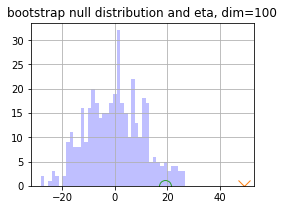

In [63]:
plt.figure(figsize=(4, 3))
plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none',markersize=12)
plt.grid()
plt.title('bootstrap null distribution and eta, dim=%d' % dim)


### 2. Estimate testing power in nrun Monte-Carlo runs

In [72]:
rho_list = 0.2/5*np.array( range(0,5)) # dim = 100

#rho_list = 1.0/5*np.array( range(0,5)) #dim = 2

rho_list

nrun = 500 #nrun = 500 as in the paper, running time is about 221 seconds on a cpu machine
           #change to nurn=100 as in the paper for shorter running time (about 46 seconds), produce similar results

# data parameter
nX, nY = 200, 200

nXtr= 100
nYtr= 100
nXte = nX-nXtr
nYte = nY-nYtr
ntr = nXtr+nYtr
nte = nXte+nYte

# training parameter
sgd_lr = 1e-3

# boostrap parameter
numperm = 400

In [73]:
dim

100

rho=0.00
-0-


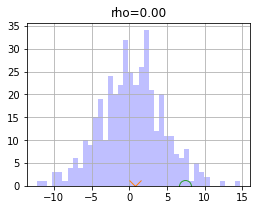

-50-
-100-
-150-
-200-
-250-
-300-
-350-
-400-
-450-
rho=0.04
-0-


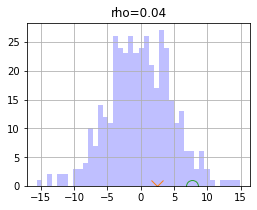

-50-
-100-
-150-
-200-
-250-
-300-
-350-
-400-
-450-
rho=0.08
-0-


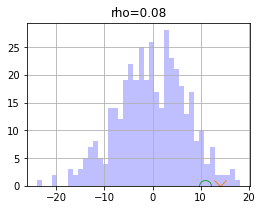

-50-
-100-
-150-
-200-
-250-
-300-
-350-
-400-
-450-
rho=0.12
-0-


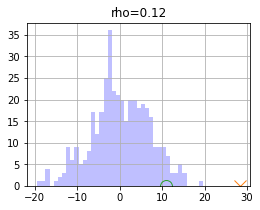

-50-
-100-
-150-
-200-
-250-
-300-
-350-
-400-
-450-
rho=0.16
-0-


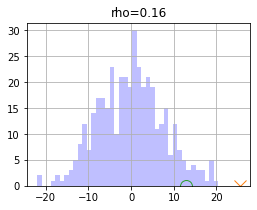

-50-
-100-
-150-
-200-
-250-
-300-
-350-
-400-
-450-
Running time: 221.49278807640076 seconds


In [74]:
import time
start = time.time() #time the code

netmmd_vote = np.zeros([ rho_list.shape[0], nrun])

for irow in range(rho_list.shape[0]):
    rho = rho_list[irow]
    print('rho=%4.2f' % rho)
    
    for irun in range(nrun):
        
        if np.mod(irun,50) ==0:
            print('-%d-' % irun)
    
        ## generate data, training-testing splitting
        X = np.float32( np.random.randn( nX, dim))
        tmp = np.float32( np.random.randn( nY, dim+1))
        Y = tmp[:,0:dim]+ np.sqrt(rho)*np.matmul(tmp[:,dim].reshape(nY,1), np.float32(np.ones(dim)).reshape((1,dim)) )
        
        idxX=torch.randperm(nX).numpy()
        idxY=torch.randperm(nY).numpy()
        data_tr = torch.tensor( np.concatenate( (X[idxX[0:nXtr],:],  Y[idxY[0:nYtr],:]), axis=0) )
        labels_tr = torch.tensor(np.concatenate( (np.zeros(nXtr),  np.ones(nYtr)), axis=0), dtype=int)
        data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
        labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)

        ## init model
        model = nn_one_hidden_layer().to(device) #init model
        # specificy 1st layer weights to be N(0,1) 
        model.fc1.weight = torch.nn.parameter.Parameter(torch.randn(model.fc1.weight.shape))
        model.fc1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.fc1.bias))
        # specificy 2nd layer weights to be N(0,1/sqrt(M)) 
        model.fc2.weight = torch.nn.parameter.Parameter(torch.randn(model.fc2.weight.shape)/np.sqrt(num_neurons))
        model.fc2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.fc2.bias))
        # make 2nd layer not trainable
        model.fc2.weight.requires_grad = False
        model.fc2.bias.requires_grad= False

        ## compute f(data_te) at t=0
        with torch.no_grad():
            fte0 = model(data_te)  
            
        ## train model 1 pass
        optimizer = optim.SGD(model.parameters(), 
                              lr=sgd_lr,
                              momentum=0, dampening=0, 
                              weight_decay=0, nesterov=False)
        model.train()
        for itr in range(0, ntr ):
            optimizer.zero_grad()
            # forward pass
            outputi = model(data_tr[itr,:]).reshape([-1,1])
            loss = F.nll_loss( torch.cat( (outputi, -outputi),1),
                              labels_tr[itr].reshape([1]), reduction='sum')
            #backward pass
            loss.backward()
            optimizer.step() 
    
        ## compute f(data_te) at t=T
        with torch.no_grad():
            fteT = model(data_te)  
        
        ## net-mmd statistic
        gte = (fteT - fte0)/sgd_lr
        idx1_te = (labels_te == 0).nonzero(as_tuple=True)[0].numpy()
        idx2_te = (labels_te == 1).nonzero(as_tuple=True)[0].numpy()
        eta = np.mean(gte[idx1_te].numpy())-np.mean(gte[idx2_te].numpy())
        
        ## test-only boostrap (permutation test)
        etastore = np.float32( np.zeros(numperm) )
        for iboot in range(numperm):
            tmp=torch.randperm(ntr).numpy()
            idx1_perm, idx2_perm = tmp[0:nXte], tmp[nXte:nte] 
            eta_perm = np.mean(gte[idx1_perm].numpy())-np.mean(gte[idx2_perm].numpy())
            etastore[iboot] = eta_perm
        talpha = np.quantile(etastore, 0.95)
        
        ## record the voet by rejection rule
        netmmd_vote[irow,irun] =  np.float32( eta > talpha )
        
        ##
        if irun == 1:
            plt.figure(figsize=(4, 3))
            plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
            plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
            plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none', markersize=12)
            plt.grid()
            plt.title('rho=%4.2f' % rho)
            plt.show()
            
end = time.time()        
print("Running time:", end - start, "seconds")  

In [77]:
# estimate testing power by sample average of vote
netmmd_power = np.mean( netmmd_vote, axis=1)
netmmd_power

array([0.058, 0.13 , 0.43 , 0.824, 0.96 ])

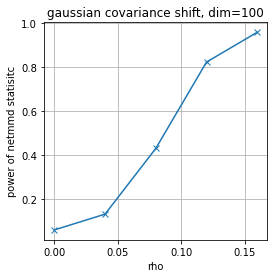

In [78]:
fig = plt.figure(figsize= (4,4))
plt.plot(rho_list, netmmd_power, 'x-')
plt.grid()
plt.ylabel('power of netmmd statisitc')
plt.xlabel('rho')
plt.title('gaussian covariance shift, dim=%d' % dim)
plt.show()
